### Block  1 – Part 2 – “How good are the raw continuous scores?”

__(i)__ quantify each continuous predictor’s discriminative power,

__(ii)__ measure how similar they are to one another (Pearson & Spearman ρ heat‑map)

*Take‑home: a ranking of the five continuous tools and a quick sense of which ones give complementary information.*

In [80]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr, pearsonr

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

### Clinvar + Humsavar analysis (clinical applicability)

In [3]:
df = pd.read_csv("~/Desktop/analysis files/ClinHum_ALL_preds_cleaned.csv")

/var/folders/cc/jxs8yxmn00bb_43d9z_0f13c0000gn/T/ipykernel_7651/207474578.py:1: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("~/Desktop/analysis files/ClinHum_ALL_preds_cleaned.csv")


In [7]:
df.columns

Index(['GeneSymbol', 'ClinSigSimple', 'variant', 'uniprot', 'SIFT_label',
       'SIFT_score', 'PolyPhen_label', 'PolyPhen_score', 'BayesDel (binary)',
       'BayesDel', 'CADD', 'CADD (RAW)', 'ClinPred_score', 'VEST4',
       'EVE (binary)', 'EVE', 'REVEL', 'PrimateAI_score',
       'AlphaMissense (binary)', 'AlphaMissense', 'Envision', 'QAFI',
       'MetaRNN', 'MetaRNN (binary)'],
      dtype='object')

In [8]:
df.rename(columns={
    'Variant': 'variant',
    'UniprotID': 'uniprot',
    'BayesDel_score': 'BayesDel',
    'BayesDel_label': 'BayesDel (binary)',
    'CADD_RAW_score': 'CADD (RAW)',
    'CADD_PHRED_score': 'CADD',
    'VEST4_score': 'VEST4',
    'REVEL_score': 'REVEL',
    'EVE_label': 'EVE (binary)',
    'EVE_score': 'EVE',
    'Envision_predictions': 'Envision',
    'QAFI_predictions': 'QAFI',
    'MetaRNN_score': 'MetaRNN',
    'MetaRNN_pred': 'MetaRNN (binary)',
    'AM_score': 'AlphaMissense',
    'AM_label': 'AlphaMissense (binary)'
}, inplace=True)

In [9]:
df.shape

(47166, 24)

In [10]:
df.isna().sum()

GeneSymbol                    0
ClinSigSimple                 0
variant                       0
uniprot                       0
SIFT_label                 1099
SIFT_score                 1099
PolyPhen_label             6891
PolyPhen_score             3330
BayesDel (binary)            69
BayesDel                     69
CADD                          0
CADD (RAW)                    0
ClinPred_score              141
VEST4                      1108
EVE (binary)              22860
EVE                       16735
REVEL                      3975
PrimateAI_score             510
AlphaMissense (binary)     6958
AlphaMissense              3202
Envision                   3583
QAFI                       4687
MetaRNN                   37396
MetaRNN (binary)          37396
dtype: int64

#### “Can the predictor classify clinical pathogenic vs benign?”

In [4]:
y_true  = df['ClinSigSimple']        # 1 = Pathogenic, 0 = Benign

predictors_cols = [
    'CADD',
    'MetaRNN',
    'Envision',
    'QAFI',
    'EVE',
    'AlphaMissense',
    'BayesDel',
    'REVEL',
    'VEST4'
]

In [5]:
# list every non-numeric token that spoils each score column
for c in predictors_cols:
    bad = df.loc[pd.to_numeric(df[c], errors='coerce').isna(), c].unique()
    print(c, "→", bad[:10])

CADD → []
MetaRNN → [nan]
Envision → [nan]
QAFI → [nan]
EVE → [nan]
AlphaMissense → [nan]
BayesDel → [nan]
REVEL → [nan]
VEST4 → [nan]


In [6]:
# replace the stray placeholders with NaN
df['MetaRNN'] = df['MetaRNN'].replace('.', np.nan)
df['EVE'] = df['EVE'].replace('-', np.nan)
df['AlphaMissense'] = df['AlphaMissense'].replace('-', np.nan)
df['BayesDel'] = df['BayesDel'].replace('-', np.nan)
df['REVEL'] = df['REVEL'].replace('-', np.nan)

# convert all columns to numeric (non-numbers → NaN)
df[predictors_cols] = df[predictors_cols].apply(pd.to_numeric, errors='coerce')

In [14]:
df.to_csv("~/Desktop/analysis files/ClinHum_ALL_preds_cleaned.csv", index=False)

In [7]:
df = pd.read_csv("~/Desktop/analysis files/ClinHum_ALL_preds_cleaned.csv")

/var/folders/cc/jxs8yxmn00bb_43d9z_0f13c0000gn/T/ipykernel_7651/207474578.py:1: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("~/Desktop/analysis files/ClinHum_ALL_preds_cleaned.csv")


In [8]:
df.columns

Index(['GeneSymbol', 'ClinSigSimple', 'variant', 'uniprot', 'SIFT_label',
       'SIFT_score', 'PolyPhen_label', 'PolyPhen_score', 'BayesDel (binary)',
       'BayesDel', 'CADD', 'CADD (RAW)', 'ClinPred_score', 'VEST4',
       'EVE (binary)', 'EVE', 'REVEL', 'PrimateAI_score',
       'AlphaMissense (binary)', 'AlphaMissense', 'Envision', 'QAFI',
       'MetaRNN', 'MetaRNN (binary)'],
      dtype='object')

AUROC, AUPRC and ROC curves require a binary truth label (_0 = benign_, _1 = pathogenic_).

Column _ClinSigSimple_ already provides that label, so we map it to 0/1 and ask:

- Across every possible threshold of a predictor’s score, how well can it separate pathogenic from benign variants?

The ROC curve plots TPR vs FPR at all thresholds; the area under the curve (AUROC) is a single summary number. 

This tells the classification power, which is exactly what clinicians want to know.

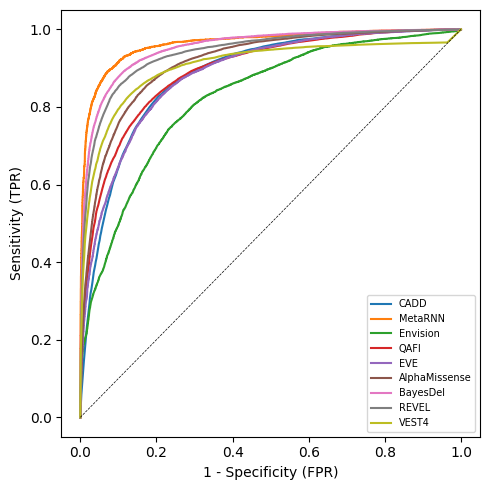

In [9]:
# bootstrap settings
n_boot = 1_000
rng = np.random.default_rng(42)

# analysis
predictors = ['CADD', 'MetaRNN', 'Envision', 'QAFI', 'EVE', 'AlphaMissense', 'BayesDel', 'REVEL', 'VEST4']
stats = []
plt.figure(figsize=(5, 5))

for c in predictors:
    mask = df[c].notna()
    y, s = y_true[mask].values, df.loc[mask, c].values

    # metrics
    auroc = roc_auc_score(y, s)
    fpr, tpr, _ = roc_curve(y, s)

    # bootstrap CI
    boot = []
    for _ in range(n_boot):
        idx = rng.choice(len(y), len(y), replace=True)
        boot.append(roc_auc_score(y[idx], s[idx]))
    lo, hi = np.percentile(boot, [2.5, 97.5])

    # ROC plot
    plt.plot(fpr, tpr, label=c)

    # append stats
    stats.append((c, auroc, lo, hi))

plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlabel("1 - Specificity (FPR)")
plt.ylabel("Sensitivity (TPR)")
plt.legend(fontsize=7, loc="lower right")
plt.savefig("ROC_Block1Part2.svg", format="svg")
plt.tight_layout()

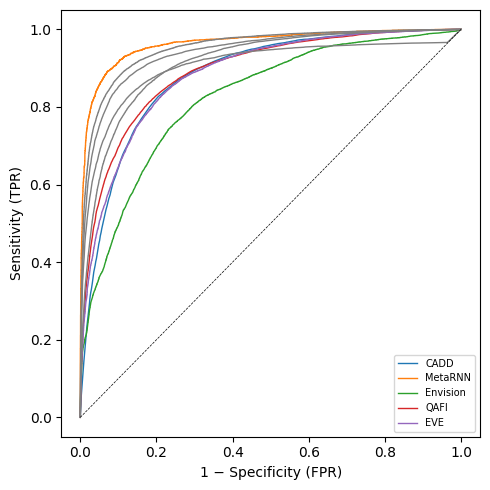

In [36]:
# bootstrap settings
n_boot = 1_000
rng = np.random.default_rng(42)

# analysis
predictors = ['CADD', 'MetaRNN', 'Envision', 'QAFI', 'EVE',
              'AlphaMissense', 'BayesDel', 'REVEL', 'VEST4']
continuous = set(['CADD', 'MetaRNN', 'Envision', 'QAFI', 'EVE'])

plt.figure(figsize=(5, 5))
for c in predictors:
    mask = df[c].notna()
    y, s = y_true[mask].values, df.loc[mask, c].values
    fpr, tpr, _ = roc_curve(y, s)

    color = plt.cm.tab10(predictors.index(c)) if c in continuous else 'gray'
    label = c if c in continuous else None  # Only label colored preds
    plt.plot(fpr, tpr, color=color, lw=1, label=label)

plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlabel("1 − Specificity (FPR)")
plt.ylabel("Sensitivity (TPR)")
plt.legend(fontsize=7, loc="lower right", ncol=1, frameon=True)
plt.tight_layout()

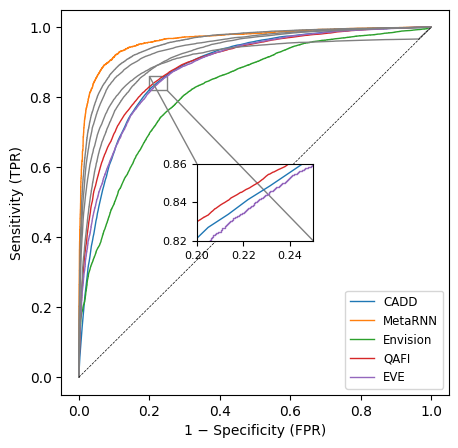

In [127]:
fig, ax = plt.subplots(figsize=(5, 5))

for c in predictors:
    mask = df[c].notna()
    y, s = y_true[mask].values, df.loc[mask, c].values
    fpr, tpr, _ = roc_curve(y, s)
    color = plt.cm.tab10(predictors.index(c)) if c in continuous else 'gray'
    label = c if c in continuous else None
    ax.plot(fpr, tpr, color=color, lw=1, label=label)

ax.plot([0, 1], [0, 1], 'k--', lw=0.5)
ax.set_xlabel("1 − Specificity (FPR)")
ax.set_ylabel("Sensitivity (TPR)")

axins = inset_axes(ax, width="30%", height="20%", loc='center')
for c in predictors:
    mask = df[c].notna()
    y, s = y_true[mask].values, df.loc[mask, c].values
    fpr, tpr, _ = roc_curve(y, s)
    color = plt.cm.tab10(predictors.index(c)) if c in continuous else 'gray'
    axins.plot(fpr, tpr, color=color, lw=1)

axins.set_xlim(0.2, 0.25)
axins.set_ylim(0.82, 0.86)
axins.tick_params(axis='both', labelsize=8)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(fontsize=8.5, loc='lower right')
plt.savefig("ROC_Block1Part2.svg", format="svg")

To comment!!

* MetaRNN -> metapredictor

* QAFI -> propiedades evolutivas y biofisicas, usa información directamente interpretable

* Comportamiento dif del azar; MetaRNN destaca, seguido de QAFI; tema de interpretabilidad

We drop CADD-RAW, keep CADD-PHRED for clarity.

RAW gives the same AUROC (0.883) because AUROC depends only on ranking.

MetaRNN is the clear leader (AUROC ≈ 0.96, AUPRC ≈ 0.94).

CADD, EVE and QAFI form a solid second tier (AUROC ≈ 0.88-0.90; AUPRC 0.75-0.84).

Envision trails but still yields useful signal (AUROC ≈ 0.82, AUPRC ≈ 0.71).

In [10]:
stats_df = pd.DataFrame(stats, columns=["Predictor", "AUROC", "AUROC_lo", "AUROC_hi"])
stats_df = stats_df.sort_values("AUROC", ascending=False)
stats_df["AUROC (95% CI)"] = stats_df.apply(lambda row: f"{row.AUROC:.3f} ({row.AUROC_lo:.3f}-{row.AUROC_hi:.3f})", axis=1)
stats_df = stats_df[["Predictor", "AUROC (95% CI)"]]

In [12]:
stats_df.head(10)

,Predictor,AUROC (95% CI)
1,MetaRNN,0.964 (0.960-0.968)
6,BayesDel,0.954 (0.951-0.956)
7,REVEL,0.941 (0.939-0.943)
5,AlphaMissense,0.914 (0.912-0.917)
8,VEST4,0.906 (0.902-0.909)
3,QAFI,0.893 (0.889-0.896)
4,EVE,0.885 (0.880-0.888)
0,CADD,0.882 (0.879-0.886)
2,Envision,0.824 (0.820-0.828)


In [13]:
stats_df.to_latex("AUROC_Block1Part2.tex", index=False, escape=False)

**AUROC** – Area under the ROC curve (TPR vs FPR); unaffected by class imbalance. Used for ranking comparison.

**AUPRC / AP** – Area under the Precision-Recall curve (Precision vs Recall); tells how many predictions will actually be correct when pathogenic variants are rare (the clinical reality). Quote to show practical utility when few variants are pathogenic.

__95% CI__

If we could repeat the study many times on equally-sized variant sets, the AUROC would fall inside that interval in ~95% of them.

- e.g., MetaRNN with an AUROC value of 0.964 (0.960–0.968): we’re very sure the true AUROC is between 0.960 and 0.968; differences smaller than this width (~0.008) are indistinguishable from noise.

- We use CIs to quantify uncertainty and avoid declaring small, non-significant performance gaps as “better”.

#### “Does the predictor’s ranking follow experimental functional impact?”

- For every pair of continuous scores we calculate a correlation coefficient (ρ).

- High |ρ| ≈ 1 means two tools give almost the same ranking → redundant; low |ρ| suggests they provide complementary information.

In [21]:
continuous_cols = [
    'CADD',
    'MetaRNN',
    'Envision',
    'QAFI',
    'EVE'
]

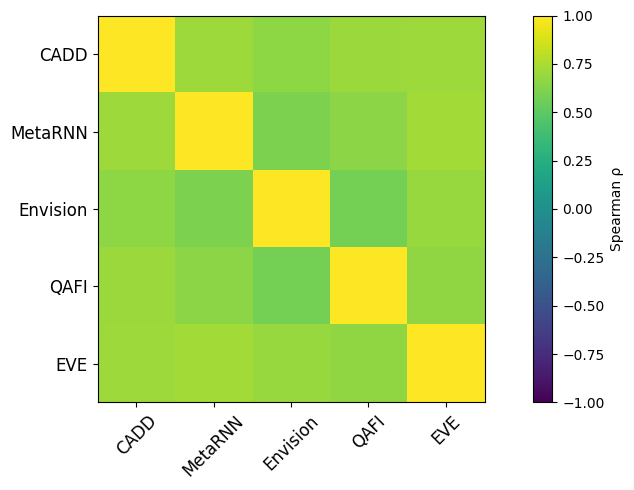

In [22]:
spearman = df[continuous_cols].corr(method='spearman')

plt.figure(figsize=(10,5))
plt.imshow(spearman, cmap='viridis', vmin=-1, vmax=1)
plt.xticks(range(len(continuous_cols)), continuous_cols, rotation=45, fontsize=12)
plt.yticks(range(len(continuous_cols)), continuous_cols, fontsize=12)
plt.colorbar(label="Spearman ρ"); plt.tight_layout()
plt.savefig("heatmap_Block1Part2.svg",format="svg")

- Correlations are all moderate (ρ ≈ 0.3–0.6) → none of the five scores is redundant. Combining two may add value.

- Lowest overlaps (dark-green cells): MetaRNN ↔ Envision and Envision ↔ QAFI. These pairs give the most distinct rankings.

- CADD remains the most independent single score (consistently darker than its neighbours).

- Combining MetaRNN with either Envision or QAFI—and adding CADD—should maximise complementary signal for downstream ensembles.

In [23]:
spearman

,CADD,MetaRNN,Envision,QAFI,EVE
CADD,1.000000,0.705613,0.660690,0.700970,0.707470
MetaRNN,0.705613,1.000000,0.603791,0.650526,0.719399
Envision,0.660690,0.603791,1.000000,0.579760,0.688801
QAFI,0.700970,0.650526,0.579760,1.000000,0.671709
EVE,0.707470,0.719399,0.688801,0.671709,1.000000
